In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
from scipy.stats import chi2_contingency, ttest_ind

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
sns.set(font_scale=1.3)

import requests
from urllib.parse import urlencode

##  Задание 1
    Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [2]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/pKMhIfP2f9tRPw'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

In [3]:
# Загружаем данные о дате регистрации пользователей

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/pKMhIfP2f9tRPw'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

register_date = pd.read_csv(download_url, sep=';')
register_date.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [4]:
# Загружаем данные о датах авторизации игроков в игру

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/-3OJerLrT5XXgQ'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

authentication_date = pd.read_csv(download_url, sep=';')
authentication_date.head(5)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [5]:
# Проверяем данные на наличие дыр
authentication_date.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [6]:
register_date.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
# Смотрим тип данных в таблицах
authentication_date.dtypes

auth_ts    int64
uid        int64
dtype: object

In [8]:
register_date.dtypes

reg_ts    int64
uid       int64
dtype: object

In [9]:
# Переводим UNIX время в дату
register_date['reg_date']        = pd.to_datetime(register_date['reg_ts'], unit='s').dt.normalize()
authentication_date['auth_date'] = pd.to_datetime(authentication_date['auth_ts'], unit='s').dt.normalize()

In [10]:
# Проверяем наличие задвоения в данных о регистрации
register_date.uid.nunique() - register_date.shape[0]

0

In [11]:
# Создаю функцию для расчета retention игроков по дням с момента регистрации по выборочному промежутку времени
# Для ее использования нужно передать строковые значения первого и последнего дня необходимого промежутка дат
def calculate_cohort(start_date, # Первый день
                     end_date, # Последний день
                     df_reg=register_date, # Данные о дате егистрации
                     df_auth=authentication_date): # Данные о датах авторизации в игре
               
    df_reg  = df_reg.query("@start_date <= reg_date <= @end_date")   # Отбираем данные по нужному промежутку времени
    df_auth = df_auth.query("@start_date <= auth_date <= @end_date")
    
    all_data = df_auth.merge(df_reg, on='uid')[['uid', 'reg_date', 'auth_date']]  # Соединяем данные о регистрации и авторзации
    all_data['days'] = (all_data.auth_date - all_data.reg_date).dt.days           # Создаем колонку с регистрацией игрока
    
    pivot = all_data.pivot_table(index='reg_date',                 # Создаем пивот таблицу, где разбиваем игроков по когортам 
                                 columns='days',                   # и считаем количество вернувшихся в игру по дням
                                 values='uid',
                                 aggfunc='count')
    
    group_count =    df_reg \
                    .groupby('reg_date') \
                    .agg({'uid': 'count'}) \
                    .rename(columns={'uid': 'Размер когорты'})     # Создаем колонку с расчетом размера выборок в когортах
    pivot = pivot.div(group_count['Размер когорты'], axis=0).round(3) # Расчитываем retention
    pivot.insert(0, 'Размер когорты', group_count['Размер когорты'])  # Вставляем в таблицу размер группы
    return  pivot                                                     # Возвращаем таблицу retention

In [12]:
# Создаю дополнительную функцию, которая возвращает retention в виде тепловой карты
# Для оптимального отображения графика рекомендуется её применять на отрезке вермени не более 25 дней
# Для использования нужно передать строковые значения первого и последнего дня необходимого промежутка дат
def calculate_cohort_heat(start_date,  # Первый день
                          end_date,  # Последний день
                          df_reg=register_date,  #Данные о дате егистрации
                          df_auth=authentication_date):  # Данные о датах авторизации в игре
    
    df_reg  = df_reg.query("@start_date <= reg_date <= @end_date")   # Отбираем данные по нужному промежутку времени
    df_auth = df_auth.query("@start_date <= auth_date <= @end_date")
    
    all_data = df_auth.merge(df_reg, on='uid')[['uid', 'reg_date', 'auth_date']]  # Соединяем данные о регистрации и авторзации
    all_data['days'] = (all_data.auth_date - all_data.reg_date).dt.days           # Создаем колонку с датой регистрацией игрока
    
    pivot = all_data.pivot_table(index='reg_date',                 # Создаем пивот таблицу, где разбиваем игроков по когортам 
                                 columns='days',                   # и считаем количество вернувшихся в игру по дням
                                 values='uid',
                                 aggfunc='count')
    
    df_reg['reg_date'] = df_reg['reg_date'].dt.date                # Меняем тип даты для нормального отображения на графике
    group_count =    df_reg \
                    .groupby('reg_date') \
                    .agg({'uid': 'count'}) \
                    .rename(columns={'uid': 'Размер когорты'})     # Создаем колонку с расчетом количества игроков в когортах
 
    retention =  pivot.div(group_count['Размер когорты'], axis=0)  # Расчитываем retention

    # Создаем 2 графика, где первый показывает когорту и количество респонеднтов в ней, второй отоброжает retention
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 10]})

        # Создаем тепловую карту retention
        sns.heatmap(retention,
                    vmax=0.1, # выставляем 10% retention как максимальное значение, для адекватного окрашивания наших данных
                    annot=True, # Выводим полученные значения в яйчейках теплового графика
                    fmt='.001%', # редактируем форматирование для отображения данных в виде процента
                    cmap='RdYlGn', # ставим тепловую карту зеленый-желтый-красный
                    ax=ax[1])
        ax[1].set_title('Возвращение игроков в игру с момента регистрации', fontsize=24, pad=30)
        ax[1].set_xlabel('День', fontsize=15, labelpad=15)
        ax[1].set_ylabel(None)
        ax[1].tick_params(axis="x", labelsize=12) 
        
        # График когорты и ее размер
        white_cmap = mcolors.ListedColormap(['white']) #Раскрашиваем цвет яйчеек тепловой карты в белый
        sns.heatmap(group_count, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0])
        ax[0].tick_params(axis="x", labelsize=12)
        ax[0].set_ylabel('Дата регистрации', fontsize=15, labelpad=25)
        ax[0].tick_params(axis="y", labelsize=12, rotation = 0) 
        
        plt.subplots_adjust(wspace=0, hspace=0) # Уменьшаем расстояние между графиками для их соединения


In [13]:
#пример работы функции
calculate_cohort("2019-01-01", "2019-01-13")

days,Размер когорты,0,1,2,3,4,5,6,7,8,9,10,11,12
reg_date,,,,,,,,,,,,,,
2019-01-01,583,1.0,0.021,0.038,0.050,0.045,0.063,0.082,0.058,0.055,0.060,0.060,0.046,0.057
2019-01-02,583,1.0,0.017,0.050,0.036,0.050,0.081,0.055,0.070,0.031,0.041,0.043,0.058,NaN
2019-01-03,585,1.0,0.017,0.031,0.044,0.060,0.063,0.065,0.058,0.022,0.050,0.048,NaN,NaN
2019-01-04,585,1.0,0.027,0.038,0.043,0.055,0.055,0.080,0.053,0.043,0.053,NaN,NaN,NaN
2019-01-05,586,1.0,0.019,0.041,0.046,0.049,0.082,0.072,0.070,0.060,NaN,NaN,NaN,NaN
2019-01-06,588,1.0,0.017,0.037,0.053,0.048,0.060,0.056,0.058,NaN,NaN,NaN,NaN,NaN
2019-01-07,588,1.0,0.017,0.043,0.041,0.054,0.073,0.073,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,589,1.0,0.031,0.041,0.051,0.058,0.071,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-09,590,1.0,0.010,0.027,0.042,0.053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


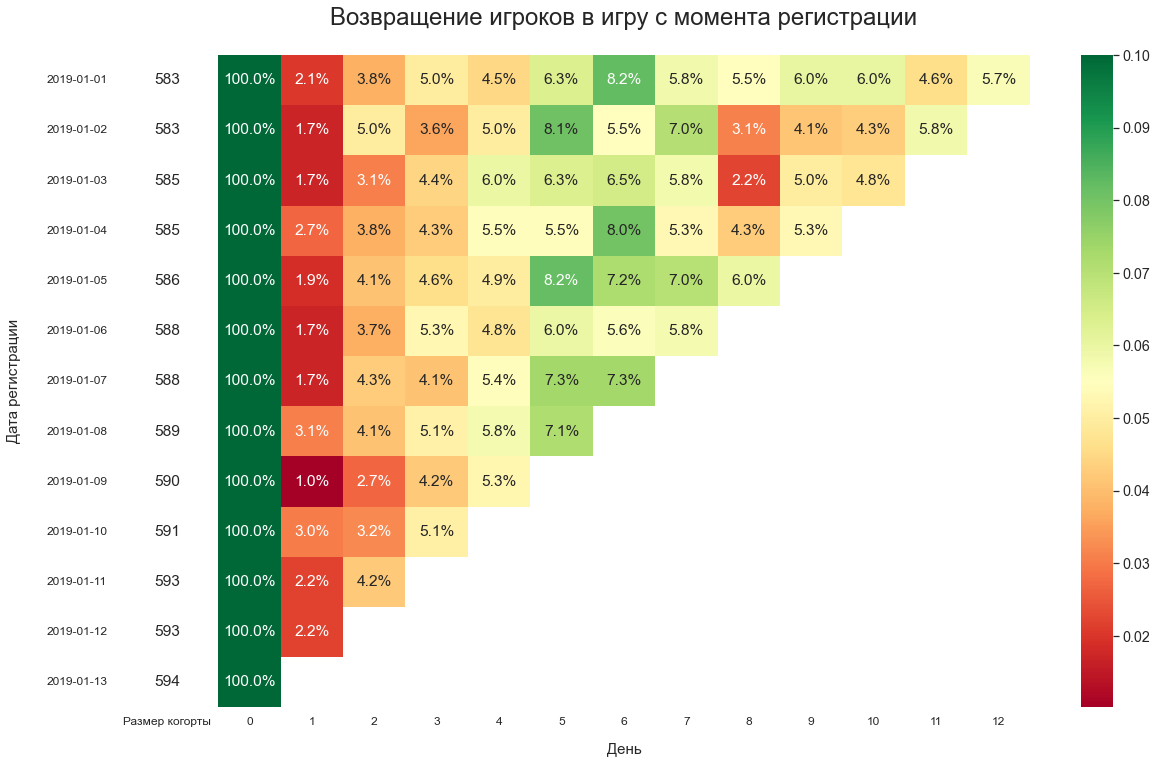

In [14]:
#пример работы функции графика
calculate_cohort_heat("2019-01-01", "2019-01-13")

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

-----------------

По хорошему сравниваемые метирики подбираются до проведения A/B теста на этапе разработки дизайна исследования. Это зависит от поставленной гипотезы, какие ожидания были от изменения акционного набора. Подходящие статистические критерии также подбираются до проведения эксперимента во время A/A тестирования, у которых доверительный интверал отношения количества ошибок на общее количество А/А тестов включает в себя 0.05, что показывает адекватную вероятность совершить ошибку первого рода

Но в данном случае мы обладаем только данными об уже проведеном эксперименте и будем подбирать необходимые метрики и критерии сравнения исходя от них. Для начала изучим полученную информацию о группах

In [15]:
# Загружаем даннные проведенного теста

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/tP36gFHxdN2JqQ'
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

test_result = pd.read_csv(download_url, sep=';')
test_result.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [16]:
# Проверяем количетсво повторяющихся юзеров в данных
test_result.user_id.nunique() - test_result.shape[0]

0

У нас есть следующая информация: каждая строка это данные об отдельном юзере, где описывается общий доход от пользователя за время проведенного эксперимента и к какой группе акционных предложений он принадлежит 

In [17]:
#Подготвим датафреймы для дальнейших расчетов

# Группы со всеми испытуемыми
A_full = test_result.query("testgroup == 'a'").revenue
B_full = test_result.query("testgroup == 'b'").revenue

# Группы с платящими испытуемыми
A_clients = test_result.query("testgroup == 'a' and revenue > 0").revenue
B_clients = test_result.query("testgroup == 'b' and revenue > 0").revenue

In [18]:
# Расчитываем конверсию из не платящего в платящие
con_a = round((A_clients.shape[0] / A_full.shape[0]) * 100, 2)
con_b = round((B_clients.shape[0] / B_full.shape[0]) * 100, 2)

# Расчитываем метрики каждой группы
metrics = pd.DataFrame(dict({'Испытуемые': [A_full.shape[0], B_full.shape[0]],
                             'Платящие': [A_clients.shape[0], B_clients.shape[0]],
                             'Convertion_%': [con_a, con_b],
                             'ARPU': [round(A_clients.sum() / A_full.shape[0], 2), round(B_clients.sum() / B_full.shape[0], 2)],
                             'ARPPU': [round(A_clients.sum() / A_clients.shape[0], 2), round(B_clients.sum() / B_clients.shape[0], 2)],
                             'Revenue': [A_clients.sum(), B_clients.sum()]}),
                       index = ['control', 'test'])

metrics = metrics.transpose()
# Расчитываем относительную разницу между контрольной и тестовой группами
metrics['relative_difference'] = round(metrics['test'] / metrics['control'] * 100 - 100, 2)
metrics

,control,test,relative_difference
Испытуемые,202103.00,202667.00,0.28
Платящие,1928.00,1805.00,-6.38
Convertion_%,0.95,0.89,-6.32
ARPU,25.41,26.75,5.27
ARPPU,2664.00,3003.66,12.75
Revenue,5136189.00,5421603.00,5.56


По относительной разницы групп мы получили следующие данные: 
 - конверсия в покупку на 6.3% меньше у тестовой по сравнению с контрольной
 - средняя выручка за каждого пользователя/общий доход выросли на ~5%
 - средняя выручка за каждого платящего выросла на 12.75%
 
С одной стороны с новым акционным набором уменьшилась конверсия в покупку, но при этом увеличилась выручка общая и за платящего пользователя. Для начала проверим есть ли статистически значимая разница в конверсиях, можем ли мы говорить о влиянии акционного набора на переход в покупку

### Хи квадрат
Нулевая гипотеза - нет статистически значимой взаимосвязи между переменными

Альтернативная гипотеза - есть статистически значимая взаимосвязь между переменными

In [19]:
# Создадим новую колонку где разделим игроков на платящих и не плятящих
test_result['segment'] = test_result.revenue.apply(lambda x: 'customer' if x > 0 else 'user')

# Получаем таблицу сопряженности платящих и не платащих пользователей тестовой и контрольной групп
user_ct = pd.crosstab(test_result.testgroup, test_result.segment)
user_ct

segment,customer,user
testgroup,,
a,1928,200175
b,1805,200862


In [20]:
# Используем хи квадрат Пирсона
stat, p, dof, expected = chi2_contingency(user_ct)
expected = list(map(lambda x: np.round(x, 0), expected))

print(f"Полученное значение: {round(stat, 3)}")
print(f"p-value: {round(p, 3)}")
print(f"Ожидаемые значения в контрольной группе:{expected[0]}")
print(f"Ожидаемые значения в тестовой группе:{expected[1]}")

Полученное значение: 4.375
p-value: 0.036
Ожидаемые значения в контрольной группе:[  1864. 200239.]
Ожидаемые значения в тестовой группе:[  1869. 200798.]


In [21]:
user_ct - pd.DataFrame(expected, columns=(['customer', 'user']), index=(['a', 'b']))

segment,customer,user
testgroup,,
a,64.0,-64.0
b,-64.0,64.0


С помощью полученных результатов мы можем отклонить нелевую гипотезу и принять альтернативную о наличии взаимосвязи между переменнными. Есть статистически значимое отличие между соотношением покупающих и не покупающих игроков в тестовой и контрольных группах. В тестовой группе меньше покупающих игроков, чем ожидаемое теоретическое значение, а в контрольной наоборот. Что может говорить о значимом отличии конверсии между контрольной и тестовой групп

### Сравнение контрольной и  тестовой групп

Для сравнения двух акционнных предложений оценим есть ли статистически значимая разница между их доходами. В данном случае для выбора более подходящего набора будет более целесообразно сравнить ARPU, так как есть значимое различие в конверсиях из не платящего в платящие и лучше оценить увеличилась ли выручка со всех пользователей с учетом уменьшения конверсии

Для подбора более подходящего статистического критерия подробно рассмотрим распределение выборок в друх группах. В графики включим только распределение купивших игроков, так как огромное количество не покупавших пользователей не даст адекватно их отобразить

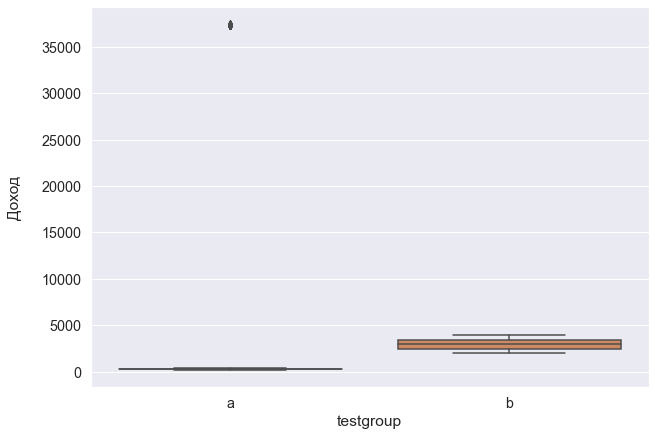

In [22]:
clients = test_result.query("revenue > 0")

plt.figure(figsize=(10, 7))
sns.boxplot(data=clients, x='testgroup', y='revenue', order=['a', 'b'], )
plt.ylabel('Доход', labelpad=20)
plt.show()

На этом графике мы видим довольно большой выброс у контрольной группы, что сплющивает значение покупок других испытуемых. Более подробно рассмотрим распределение дохода пользователей в каждой группе без выбросов

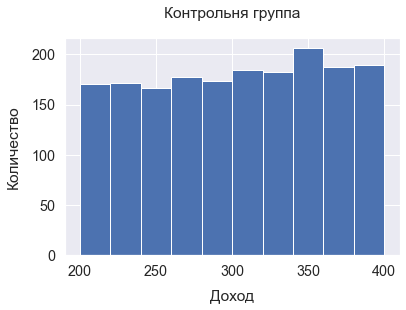

In [23]:
# Распределение дохода от платящих пользователей контрольной группы
plt.hist(clients.query("testgroup == 'a' and revenue < 10000").revenue, bins=10)
plt.ylabel('Количество', labelpad=10)
plt.xlabel('Доход', labelpad=10)
plt.title('Контрольня группа', pad=20)
plt.show()

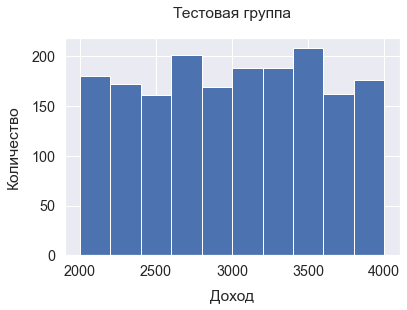

In [24]:
# Распределение дохода от платящих пользователей тестовой группы
plt.hist(clients.query("testgroup == 'b'").revenue)
plt.ylabel('Количество', labelpad=10)
plt.xlabel('Доход', labelpad=10)
plt.title('Тестовая группа', pad=20)
plt.show()

In [25]:
# Количество игроков в контрольной группе с покупками на сумму в районе 37 000
clients.query("testgroup == 'a' and revenue > 10000").shape[0]

123

In [26]:
# Процент игроков с огромными покупками от покупающих игроков в контрольной группе
print(str(round(clients.query("testgroup == 'a' and revenue > 10000").shape[0] / B_clients.shape[0] * 100, 2)) + '%')

6.81%


Как видно по графикам, в контрольной группе равномерное распределение доходов от покупающих игроков с границей 200-400, но есть довольно сильный выброс в покупках, который составляет 6.81% от покупающих игроков в группе (123 испытуемых). В тестовой группе также равномерное распределение, границы revenue 2000-4000 и отстутвие выбросов

------

В данном случае будет не совсем валидно воспользоваться t-тестом Стьюдента из-за наличия большого выброса в контрольной группе, которые двольно сильно исказят среднее значение

Также не совсем правильно будет применять критерий Манна-Уитни из-за огромного количества пересекающихся испытыуемых в значении 0. Можно использовать этот критерий при большом количестве нулей в выборках, но в нашем случае это больше 99% испытуемых, что значимо исказит наш p-value

Мы можем прологорифмировать доход с каждого игрока, чтобы оштрафовать выбросы из контрольной группы и уменьшить их влияение на среднее значение дохода в группе. В этом случае мы сможем воспользоваться t-тестом Стьюдента

---

Н0 гипотеза - среднее значение дохода прологарифмированных выборок не имеют различий

Н1 гипотеза - среднее значение дохода прологарифмированных выборок не равны

In [27]:
ttest_ind(np.log(A_full + 1), np.log(B_full + 1)) # Добавляем ко всем значениям единицу, так как логарифм от 0 взять нельзя

Ttest_indResult(statistic=-6.5121724164204435, pvalue=7.415779073120386e-11)

### Вывод
Полученное значение p_value позволяет отклонить нулевую гипотезу и принять альтернативную. Среднее значение дохода логарифмированной тестовой выборки имеет статистичесски значимо больше среднего логарифмированной контрольной группы. С учетом штрафования больших значений в контрольной группе, новое акционное предложение повышает среднее значение выручки с каждого пользователя и лучше его ввести вместо старого, даже с учетом того, что конверсия в покупку у нового акционного набора будет меньше

Но в то же время будет несправедливо закрыть глаза на тех пользователей, которые совершили крупные покупки в контрольной выборке. Хоть их средний доход значимо выбивается от других испытуемых, из-за чего мы их приписываем к выбросам, они составляют 6.81% от общей суммы покупающих игроков в контрольной группе. Что может быть совсем не случайностью и они являются другим сегметом игроков, которых привлекает старое акционное предложение, которое их побуждает тратить огромные суммы денег и приносит довольно высокий доход с одного пользователя. В таком случае этот же сегмент пользователей в тестовой группе вместо таких же покупок на большой чек, как в контрольной выборке, купил не больше среднего покупающего игрока или решил вовсе не тратить из-за отстутствия подходящего акционного набора 

Если в проведенном эксперименте нет ошибки системы сплитования и распределение испытуемых по выборкам произошло корректно, тогда нужно будет более детально изучить данную подгруппу пользователей, выделить их в отдельный сегмент и, если возможно, оставить акционное предложение им без изменений или более детально изучить их интересы и понять почему новый набор их не привлек

## Задание 3
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

------------------------

Тематические события в игре используются для дополнительного удержания игрока в игре. В ивентах нужно грамотно настроить сложность прохождения. Если он будет очень простым, то его быстро пройдут или он будет очень скучным и не принесет удовлетворения от прохождения. Если будет довольно сложным, то большая часть игроков может быстро забросить так и не пройдя его. Главное найти баланс, где участники получали удовольствие от достижения новых уровней и хотели все больше и больше проходить

В обоих случаях я бы смотрел на несколько метрик: 
- конверсию игроков участовавших в ивенте/заходившие в игру во время ивента. Показывает на сколько мероприятие заиинтересовало игроков поучаствовать в нем, на сколько вовлекающим сделали ивент
- Среднее количество пройденных уровней. Эта метрика индивидуальна для каждого мероприятия и должна соответствовать ожидаемому количеству пройденных уровней, на сколько задумывали сделать мероприятие сложным, на какой сегмент игроков был расчитан ивент.
- Среднее время прохождения ивента. Метрика показывает на сколько смогли удержать игрока в игре, чем она выше, тем лучше ивент справился со своей задачей

Дополнительно к новому событию я бы добавил сотношение количества продолжения участия в мероприятии на общее количество неудачных попыток. Этот показатель будет говорить о том на сколько игрок готов продолжать участвовать в ивенте после отката назад, не отбивает ли неудача желаение продолжить проходить уровни

Главными показателями успешности проведенного мероприятия будет "соотношение игроков участовавших в ивенте/заходившие в игру во время ивента" и "Среднее время прохождения ивента". Эти метрики покажут на сколько много игроков событие смогло привлечь и на сколько долго удержать их в игре. Чем больше пользователь заходит в игру и проводит в ней время, тем более лояльным он становится к ней

Если увеличение сложности приведет к благоприятным последтвиям, то игроки не должны испугаться нововведений и количество вовлеченных не должно уменьшиться. Также общее количество времени проведенного за игровым событием должно увеличиться, так как теперь придется тратить дополнительное время на прохождение уровней повторно при неудачной попытке выполнения